In [1]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agents.rbc import RBC

/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/pyparsing.py:943: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  collections.MutableMapping.register(ParseResults)
/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [3]:
# Simulation without energy storage
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(9)])
cost_no_storage, cost_no_storage_last_yr = env.cost()

In [4]:
env.cost()

({'ramping': 0.7069866,
  '1-load_factor': 0.9071280829496887,
  'average_daily_peak': 0.8132976,
  'peak_demand': 0.91218215,
  'net_electricity_consumption': 0.96940136,
  'carbon_emissions': 0.99152404,
  'total': 0.8834199784925861,
  'coordination_score': 0.8348986176746017},
 {'ramping_last_yr': 0.7079259,
  '1-load_factor_last_yr': 0.9235959367464537,
  'average_daily_peak_last_yr': 0.8172352,
  'peak_demand_last_yr': 0.9287422,
  'net_electricity_consumption_last_yr': 0.9713933,
  'carbon_emissions_last_yr': 0.99829054,
  'coordination_score_last_yr': 0.8443747986483214,
  'total_last_yr': 0.884508259887329})

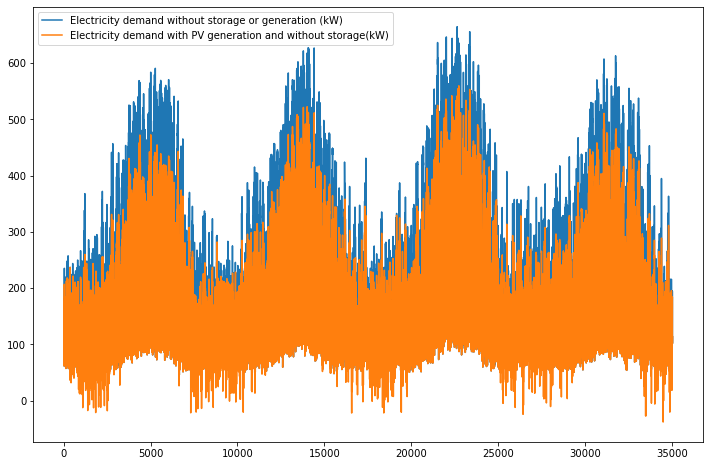

In [5]:
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])

In [6]:
# RULE-BASED CONTROLLER (RBC) (Stores energy at night and releases it during the day)
# In this example, each building has its own RBC, which tries to flatten a generic building load 
# by storing energy at night and using it during the day, which isn't necessarily the best solution 
# in order to flatten the total load of the district.
# Select the climate zone and load environment

'''IMPORTANT: Make sure that the buildings_state_action_space.json file contains the hour of day as 3rd true state:
{"Building_1": {
    "states": {
        "month": true,
        "day": true,
        "hour": true
Alternative, modify the line: "hour_day = states[0][2]" of the RBC_Agent Class in agent.py
'''
import json
import time
# Instantiating the control agent(s)
agents = RBC(actions_spaces)

# Finding which state 
with open('buildings_state_action_space.json') as file:
    actions_ = json.load(file)

indx_hour = -1
for obs_name, selected in list(actions_.values())[0]['states'].items():
    indx_hour += 1
    if obs_name=='hour':
        break
    assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
        

state = env.reset()
done = False
rewards_list = []
start = time.time()
while not done:
    hour_state = np.array([[state[0][indx_hour]]])
    action = agents.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()
end = time.time()
print(end-start)

23.84124183654785


In [7]:
rbc_net = env.net_electric_consumption[31000+1500+89:31000+1500+89+24*7]
print(np.array(rbc_net))

[310.9919 276.4165 251.3007 252.0769 242.6797 218.736  204.1341 202.9352
 261.6892 356.5466 431.8923 172.7177 188.7128 180.8368 194.3574 218.0963
 238.58   258.4785 273.2576 280.0511 236.2863 254.6249 276.5362 229.4789
 333.6707 304.4746 257.194  271.2663 256.6035 248.084  233.7731 229.6424
 292.2098 410.146  451.3731 188.3759 180.4575 206.3824 204.8917 253.8476
 264.6343 282.4195 306.2142 289.982  249.4994 248.0468 253.89   226.95
 355.9387 323.9571 296.2212 259.3165 234.1193 200.9055 192.9745 216.0655
 319.1462 391.0162 396.5437 126.9724 158.4588 179.4998 168.4099 181.0655
 200.0288 206.9164 212.0921 213.901  145.1121 155.8664 190.9863 192.2962
 341.6502 312.4384 266.2465 272.6979 249.0482 218.4342 212.2989 203.3866
 234.811  294.8616 271.1754 104.0119  44.3649  51.3922  53.598   90.8216
 116.1236 135.7882 133.56   120.7154 143.7338 111.1947 136.8508 140.5775
 312.3802 286.0892 260.5428 259.9232 241.4606 255.5678 250.0348 238.2695
 282.8001 325.357  361.384  139.9051 143.0917 156.497

In [8]:
1.18602800e-01 + 0.034*2

0.1866028

In [9]:
cost_rbc

({'ramping': 1.0,
  '1-load_factor': 1.0,
  'average_daily_peak': 1.0,
  'peak_demand': 1.0,
  'net_electricity_consumption': 1.0,
  'carbon_emissions': 1.0,
  'total': 1.0,
  'coordination_score': 1.0},
 {'ramping_last_yr': 1.0,
  '1-load_factor_last_yr': 1.0,
  'average_daily_peak_last_yr': 1.0,
  'peak_demand_last_yr': 1.0,
  'net_electricity_consumption_last_yr': 1.0,
  'carbon_emissions_last_yr': 1.0,
  'coordination_score_last_yr': 1.0,
  'total_last_yr': 1.0})

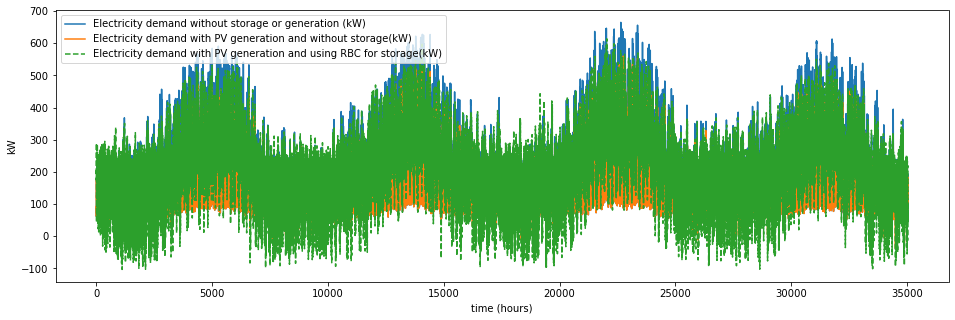

In [12]:
# Plotting electricity consumption breakdown
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

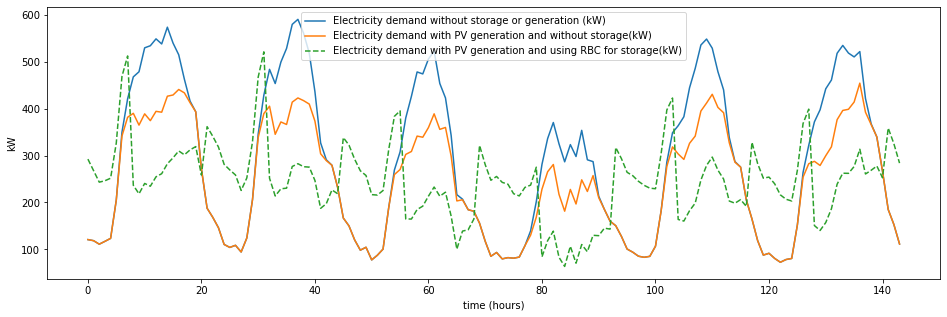

In [17]:
# Plotting 5 days of winter operation of year 1
plt.figure(figsize=(16,5))
interval = range(7*24*30 + 8*24, 7*24*30 + 8*24 + 6*24)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

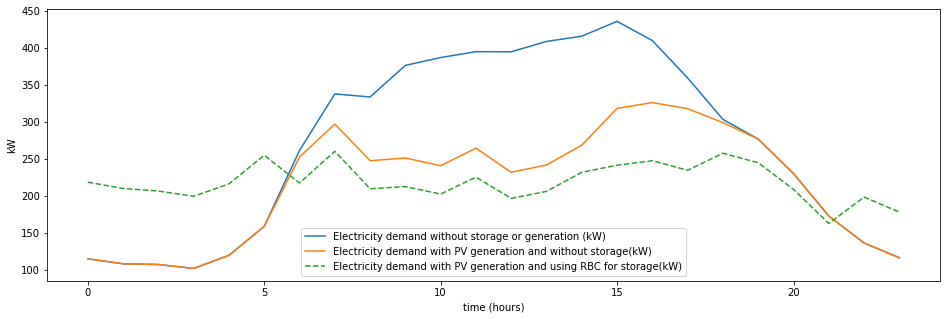

In [10]:
# Plotting summer operation of year 1
plt.figure(figsize=(16,5))
interval = range(24*30*7,24*30*7 + 24)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

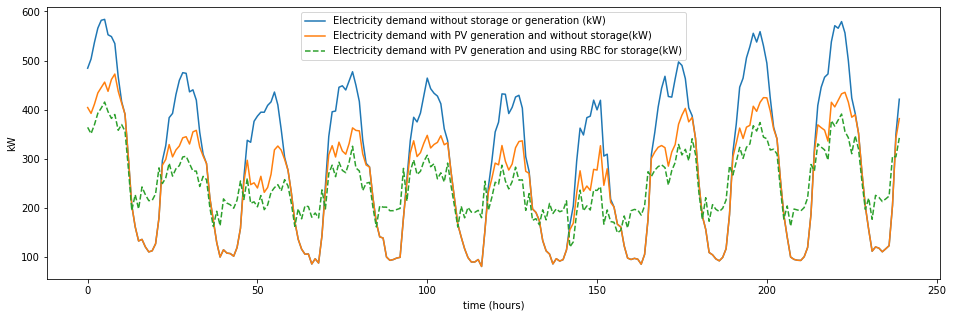

In [11]:
# Plotting summer operation
interval = range(5000,5000 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

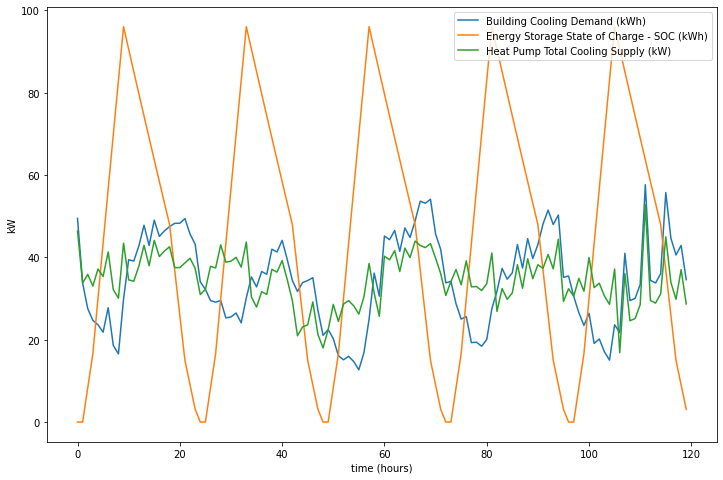

In [11]:
# Plot for one building of the total cooling supply, the state of charge, and the actions of the controller during winter
building_number = 'Building_5'
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_storage_soc[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_device_to_building[3500:3500+24*5] + env.buildings[building_number].cooling_device_to_storage[3500:3500+24*5])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Building Cooling Demand (kWh)','Energy Storage State of Charge - SOC (kWh)', 'Heat Pump Total Cooling Supply (kW)'])

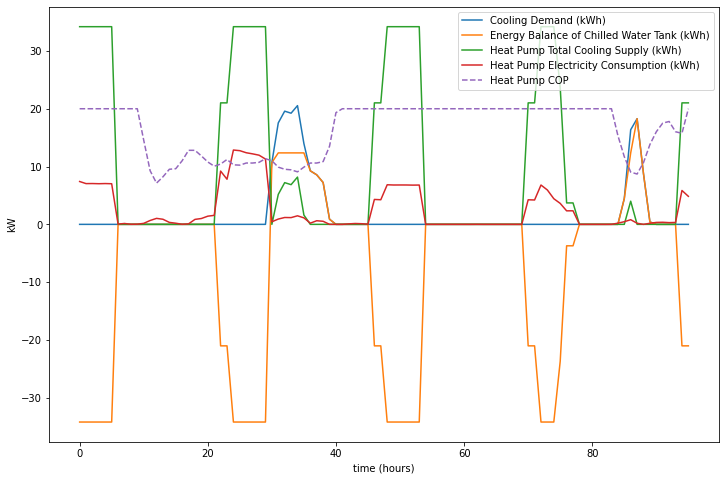

In [12]:
building_number = 'Building_1'
interval = range(0,24*4)
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[interval])
plt.plot(env.buildings[building_number].cooling_storage_to_building[interval] - env.buildings[building_number].cooling_device_to_storage[interval])
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[interval])
plt.plot(env.electric_consumption_cooling[interval])
plt.plot(env.buildings[building_number].cooling_device.cop_cooling[interval],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)','Energy Balance of Chilled Water Tank (kWh)', 'Heat Pump Total Cooling Supply (kWh)', 'Heat Pump Electricity Consumption (kWh)','Heat Pump COP'])